In [ ]:
import keras
from keras import layers
import numpy as np

In [ ]:
original_dim = 28 * 28
intermediate_dim = 64
intermediate_dim1 = 32
intermediate_dim2 = 16
intermediate_dim3 = 8
latent_dim = 5

In [ ]:
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 5)


In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = layers.Dense(intermediate_dim1, activation='relu')(x)
x = layers.Dense(intermediate_dim2, activation='relu')(x)
x = layers.Dense(intermediate_dim3, activation='relu')(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_49 (Dense)               (None, 64)           50240       ['input_4[0][0]']                
                                                                                                  
 dense_50 (Dense)               (None, 5)            325         ['dense_49[0][0]']               
                                                                                                  
 dense_51 (Dense)               (None, 5)            325         ['dense_49[0][0]']               
                                                                                            

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 5)]               0         
                                                                 
 dense_52 (Dense)            (None, 64)                384       
                                                                 
 dense_53 (Dense)            (None, 32)                2080      
                                                                 
 dense_54 (Dense)            (None, 16)                528       
                                                                 
 dense_55 (Dense)            (None, 8)                 136       
                                                                 
 dense_56 (Dense)            (None, 784)               7056      
                                                                 
Total params: 10,184
Trainable params: 10,184
Non-trainable

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [ ]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 5),          50890       ['input_4[0][0]']                
                                 (None, 5),                                                       
                                 (None, 5)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          10184       ['encoder[0][2]']                
                                                                                            

In [ ]:
vae.compile(optimizer='adam')

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=5,
        batch_size=32)
        #validation_data=(x_test, x_test))

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 185.0820
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 149.9651
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 143.7624
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 140.0482
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 137.6254


In [ ]:
x_decoded_vae = vae.predict(x_train)

In [ ]:
x_decoded_vae.shape

(60000, 784)

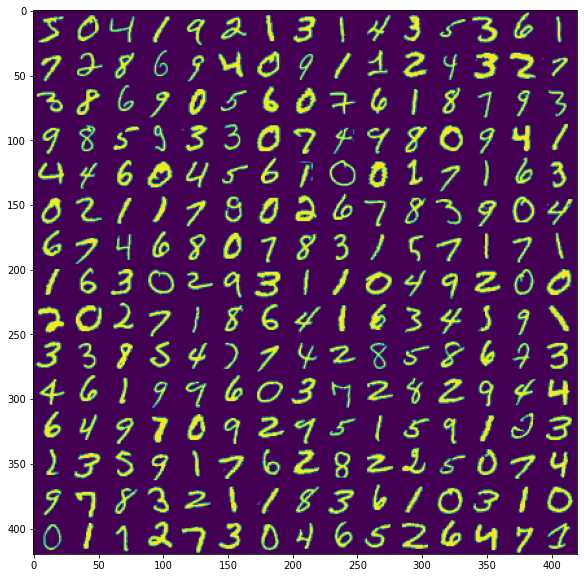

In [ ]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

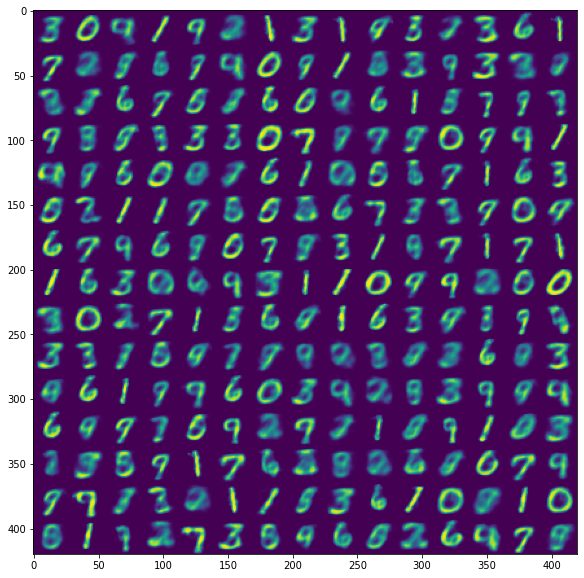

In [ ]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_decoded_vae[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:
z_zz = encoder.predict(x_train)
print (z_zz[2].shape)
print (z_zz[2][0].shape)

(60000, 5)
(5,)


In [ ]:
x_decoded_decoder0 = decoder.predict(z_zz[2]+0.05)
x_decoded_decoder1 = decoder.predict(z_zz[0]+z_zz[1] * 0.7)

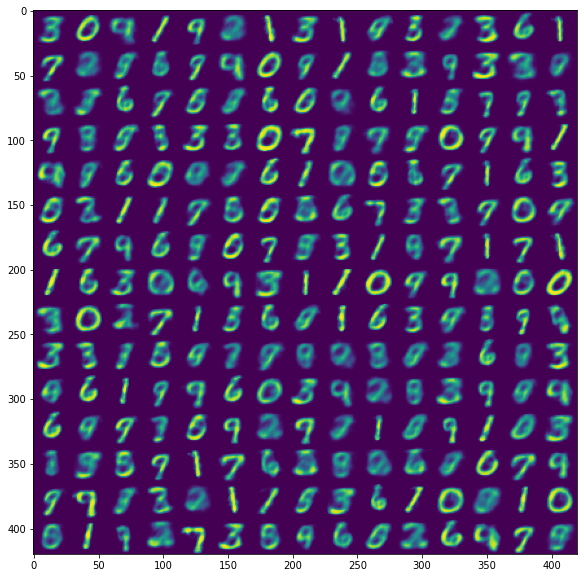

In [ ]:
import matplotlib.pyplot as plt

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded_decoder0[k].reshape(digit_size, digit_size)
        #digit = x_decoded_decoder1[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
